<a href="https://colab.research.google.com/github/abdheshdash8/Deconfounding-Recommender-Systems/blob/main/deconfounded_recommender1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd

COAT_PATH = '/content/drive/MyDrive/Colab Notebooks/coat/'
YAHOO_PATH = '/content/drive/MyDrive/Colab Notebooks/yahoo!r3/'

# Load Coat
train = np.loadtxt(COAT_PATH + 'train.ascii')
test = np.loadtxt(COAT_PATH + 'test.ascii')
prop = np.loadtxt(COAT_PATH + 'propensities.ascii')

n_users, n_items = train.shape
print(f"Coat: {n_users} users × {n_items} items")

# Convert to triplets (u, i, rating)
train_u, train_i = np.where(train > 0)
train_df_coat = pd.DataFrame({
    "u": train_u,
    "i": train_i,
    "rating": train[train_u, train_i]
})
test_u, test_i = np.where(test > 0)
test_df_coat = pd.DataFrame({
    "u": test_u,
    "i": test_i,
    "rating": test[test_u, test_i]
})

# Add inverse propensity weights (IPW)
train_df_coat["ipw"] = 1.0 / np.clip(prop[train_df_coat.u, train_df_coat.i], 1e-3, None)
print(train_df_coat.head())


Coat: 290 users × 300 items
   u    i  rating        ipw
0  0   72     2.0  65.336856
1  0  136     2.0  51.300279
2  0  150     3.0   5.038305
3  0  171     3.0   5.438403
4  0  188     3.0   6.683744


In [ ]:
import numpy as np
import pandas as pd

train_yahoo = pd.read_csv(YAHOO_PATH + 'user.txt', sep=',', header=None, names=['u','i','rating'])
test_yahoo  = pd.read_csv(YAHOO_PATH + 'random.txt', sep=',', header=None, names=['u','i','rating'])

n_users = int(train_yahoo.u.max() + 1)
n_items = int(train_yahoo.i.max() + 1)
print(f"Yahoo! R3: {n_users} users × {n_items} items")

# Binary exposure matrix (1 = rated, 0 = not rated)
A = np.zeros((n_users, n_items), dtype=np.int8)
for _, row in train_yahoo.iterrows():
    A[int(row.u), int(row.i)] = 1



Yahoo! R3: 15400 users × 1000 items


In [ ]:
# from sklearn.decomposition import NMF

# K_exp = 20
# nmf = NMF(n_components=K_exp, init='nndsvda', max_iter=400, random_state=0)
# W = nmf.fit_transform(A)
# H = nmf.components_.T
# A_tilde = W @ H.T
# prop_est = np.clip(A_tilde, 1e-3, 1.0)

# # Assign inverse propensities
# train_yahoo["ipw"] = 1.0 / prop_est[train_yahoo.u, train_yahoo.i]


In [ ]:
# import numpy as np

# def dcg_at_k(r, k):
#     r = np.asarray(r)[:k]
#     if r.size:
#         return np.sum((2**r - 1) / np.log2(np.arange(2, r.size + 2)))
#     return 0.0

# def ndcg_at_k(y_true, y_score, k=5):
#     order = np.argsort(y_score)[::-1]
#     rel = np.take(y_true, order)
#     return dcg_at_k(rel, k) / (dcg_at_k(sorted(rel, reverse=True), k) + 1e-9)

# def recall_at_k(y_true, y_score, k=5, threshold=3):
#     rel = (np.array(y_true) >= threshold).astype(int)
#     order = np.argsort(y_score)[::-1][:k]
#     return rel[order].sum() / (min(k, rel.sum() + 1e-9))

In [ ]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import os

# Use float32 everywhere
torch.set_default_dtype(torch.float32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# metrics
def dcg_at_k(r, k):
    r = np.asarray(r)[:k]
    if r.size:
        return np.sum((2**r - 1) / np.log2(np.arange(2, r.size + 2)))
    return 0.0

def ndcg_at_k(y_true, y_score, k=5):
    # y_true, y_score are arrays of same length for a user
    order = np.argsort(y_score)[::-1]
    rel = np.take(y_true, order)
    denom = dcg_at_k(sorted(rel, reverse=True), k)
    return (dcg_at_k(rel, k) / (denom + 1e-12))

def recall_at_k(y_true, y_score, k=5, threshold=3):
    rel = (np.array(y_true) >= threshold).astype(int)
    order = np.argsort(y_score)[::-1][:k]
    return rel[order].sum() / (min(k, rel.sum()) + 1e-12)

def evaluate_ranking_on_random_test(model_predict_fn, test_df, n_users, k=5, threshold=3, deconf_tilde=None):
    """
    model_predict_fn gives numpy scores
    test_df contains columns ['u','i','rating']
    deconf_tilde: DeconfMF model needs tilde values
    Returns mean NDCG and mean Recall averaged over users with test items.
    """
    test_df = test_df.reset_index(drop=True)
    users = test_df['u'].unique()
    ndcgs, recalls = [], []
    for u in users:
        sub = test_df[test_df['u']==u]
        items = sub['i'].values
        y_true = sub['rating'].values
        if len(items) == 0:
            continue
        if deconf_tilde is None:
            scores = model_predict_fn(np.array([u]*len(items)), items)
        else:
            # model_predict_fn can accept (u_array, i_array, tilde_array)
            tilde_vals = deconf_tilde[items] if deconf_tilde.ndim==1 else deconf_tilde[u, items]
            scores = model_predict_fn(np.array([u]*len(items)), items, tilde_vals)
        ndcgs.append(ndcg_at_k(y_true, scores, k=k))
        recalls.append(recall_at_k(y_true, scores, k=k, threshold=threshold))
    return np.mean(ndcgs) if len(ndcgs)>0 else 0.0, np.mean(recalls) if len(recalls)>0 else 0.0


Device: cpu


In [ ]:
# Model classes
class MFModel(nn.Module):
    def __init__(self, n_users, n_items, K=10):
        super().__init__()
        self.user_factors = nn.Embedding(n_users, K)
        self.item_factors = nn.Embedding(n_items, K)
        self.bias = nn.Parameter(torch.tensor(0.0))
    def forward(self, u, i):
        pred = (self.user_factors(u) * self.item_factors(i)).sum(dim=1)
        return pred + self.bias

class DeconfMF(nn.Module):
    def __init__(self, n_users, n_items, K=10):
        super().__init__()
        self.user_factors = nn.Embedding(n_users, K)
        self.item_factors = nn.Embedding(n_items, K)
        self.gamma = nn.Embedding(n_users, 1)
        self.bias = nn.Parameter(torch.tensor(0.0))
    def forward(self, u, i, tilde):
        pred = (self.user_factors(u) * self.item_factors(i)).sum(dim=1)
        pred = pred + (self.gamma(u).squeeze() * tilde)
        return pred + self.bias

# Training utilities
def train_mf_fullbatch(model, train_u, train_i, train_y, epochs=50, lr=0.01, verbose=False):
    model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    loss_fn = nn.MSELoss()
    train_u_t = torch.tensor(train_u, dtype=torch.long, device=device)
    train_i_t = torch.tensor(train_i, dtype=torch.long, device=device)
    train_y_t = torch.tensor(train_y, dtype=torch.float32, device=device)
    losses = []
    for ep in range(epochs):
        model.train()
        opt.zero_grad()
        preds = model(train_u_t, train_i_t)
        loss = loss_fn(preds, train_y_t)
        loss.backward()
        opt.step()
        losses.append(loss.item())
        if verbose and (ep+1)%10==0:
            print(f"Epoch {ep+1}/{epochs}, loss={loss.item():.4f}")
    return losses

def train_ipw_mf_fullbatch(model, train_u, train_i, train_y, weights, epochs=50, lr=0.01, verbose=False):
    # weights is numpy array aligned with train rows
    model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    train_u_t = torch.tensor(train_u, dtype=torch.long, device=device)
    train_i_t = torch.tensor(train_i, dtype=torch.long, device=device)
    train_y_t = torch.tensor(train_y, dtype=torch.float32, device=device)
    weights_t = torch.tensor(weights, dtype=torch.float32, device=device)
    losses = []
    for ep in range(epochs):
        model.train()
        opt.zero_grad()
        preds = model(train_u_t, train_i_t)
        loss_vec = (preds - train_y_t)**2
        loss = (weights_t * loss_vec).mean()
        loss.backward()
        opt.step()
        losses.append(loss.item())
        if verbose and (ep+1)%10==0:
            print(f"Epoch {ep+1}/{epochs}, IPW loss={loss.item():.4f}")
    return losses

def train_deconf_fullbatch(model, train_u, train_i, train_y, train_tilde, epochs=50, lr=0.01, verbose=False):
    model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    train_u_t = torch.tensor(train_u, dtype=torch.long, device=device)
    train_i_t = torch.tensor(train_i, dtype=torch.long, device=device)
    train_y_t = torch.tensor(train_y, dtype=torch.float32, device=device)
    train_tilde_t = torch.tensor(train_tilde, dtype=torch.float32, device=device)
    losses = []
    for ep in range(epochs):
        model.train()
        opt.zero_grad()
        preds = model(train_u_t, train_i_t, train_tilde_t)
        loss = nn.functional.mse_loss(preds, train_y_t)
        loss.backward()
        opt.step()
        losses.append(loss.item())
        if verbose and (ep+1)%10==0:
            print(f"Epoch {ep+1}/{epochs}, Deconf loss={loss.item():.4f}")
    return losses


In [ ]:
COAT_PATH = '/content/drive/MyDrive/Colab Notebooks/coat/'
YAHOO_PATH = '/content/drive/MyDrive/Colab Notebooks/yahoo!r3/'

# COAT
train_mat_coat = np.loadtxt(os.path.join(COAT_PATH, 'train.ascii'))
test_mat_coat = np.loadtxt(os.path.join(COAT_PATH, 'test.ascii'))
prop_mat_coat = np.loadtxt(os.path.join(COAT_PATH, 'propensities.ascii'))

n_users_coat, n_items_coat = train_mat_coat.shape
print("Coat shape:", n_users_coat, n_items_coat)

train_u, train_i = np.where(train_mat_coat > 0)
train_r = train_mat_coat[train_u, train_i]
train_df_coat = pd.DataFrame({"u": train_u.astype(int), "i": train_i.astype(int), "rating": train_r.astype(float)})
test_u, test_i = np.where(test_mat_coat > 0)
test_r = test_mat_coat[test_u, test_i]
test_df_coat = pd.DataFrame({"u": test_u.astype(int), "i": test_i.astype(int), "rating": test_r.astype(float)})

# ipw weights from provided propensities
train_df_coat['ipw'] = 1.0 / np.clip(prop_mat_coat[train_df_coat.u.values, train_df_coat.i.values], 1e-3, None)
print("Coat train rows:", len(train_df_coat), "test rows:", len(test_df_coat))


Coat shape: 290 300
Coat train rows: 6960 test rows: 4640


In [ ]:
train_yahoo = pd.read_csv(os.path.join(YAHOO_PATH, 'user.txt'), sep=',', header=None, names=['u','i','rating'])
test_yahoo = pd.read_csv(os.path.join(YAHOO_PATH, 'random.txt'), sep=',', header=None, names=['u','i','rating'])
try:
    samp = pd.read_csv(os.path.join(YAHOO_PATH, 'sampling_data.txt'), sep=',', header=None)
except Exception:
    samp = None

# IDs assumed already 0-indexed
n_users_yahoo = int(max(train_yahoo.u.max(), test_yahoo.u.max()) + 1)
n_items_yahoo = int(max(train_yahoo.i.max(), test_yahoo.i.max()) + 1)
print("Yahoo R3 shape:", n_users_yahoo, n_items_yahoo)

# exposure binary matrix A_train for Yahoo
A_yahoo = np.zeros((n_users_yahoo, n_items_yahoo), dtype=int)
for _, row in train_yahoo.iterrows():
    A_yahoo[int(row.u), int(row.i)] = 1

# convert train/test to DataFrames with int indices
train_df_yahoo = train_yahoo[['u','i','rating']].astype({'u':int,'i':int,'rating':float}).reset_index(drop=True)
test_df_yahoo = test_yahoo[['u','i','rating']].astype({'u':int,'i':int,'rating':float}).reset_index(drop=True)

# Estimate propensities p_hat via NMF on A_yahoo
K_exp = 40
nmf_model = NMF(n_components=K_exp, init='nndsvda', max_iter=800, random_state=SEED)
W = nmf_model.fit_transform(A_yahoo)
H = nmf_model.components_.T
A_tilde_yahoo = W.dot(H.T)  # real-valued exposure intensity
# scale to (eps, 1-eps) and treat as propensity estimates
scaler = MinMaxScaler(feature_range=(1e-3, 0.999))
p_hat_flat = scaler.fit_transform(A_tilde_yahoo.reshape(-1,1)).reshape(A_tilde_yahoo.shape)
p_hat_yahoo = np.clip(p_hat_flat, 1e-3, 0.999)

# ipw calculation for train_df_yahoo
train_df_yahoo['ipw'] = 1.0 / p_hat_yahoo[train_df_yahoo.u.values, train_df_yahoo.i.values]
# clip extreme weights
clip_val = np.percentile(train_df_yahoo['ipw'].values, 99)
train_df_yahoo['ipw'] = np.clip(train_df_yahoo['ipw'].values, None, clip_val)

print("Yahoo train rows:", len(train_df_yahoo), "test rows:", len(test_df_yahoo))


Yahoo R3 shape: 15400 1000
Yahoo train rows: 311704 test rows: 54000


In [ ]:
# Run the models on a given dataset (DataFrames) and return metrics & training losses
def run_models_on_dataset(train_df, test_df, n_users, n_items, A_tilde=None,
                          K=32, epochs=80, lr=0.01, verbose=False):
    # Data arrays
    train_u = train_df['u'].values.astype(int)
    train_i = train_df['i'].values.astype(int)
    train_y = train_df['rating'].values.astype(float)
    # IPW weights
    if 'ipw' in train_df.columns:
        train_w = train_df['ipw'].values.astype(float)
    else:
        train_w = None

    if A_tilde is not None:
        train_tilde = A_tilde[train_u, train_i].astype(float)
    else:
        train_tilde = None

    # Training Baseline MF
    mf_model = MFModel(n_users, n_items, K).to(device)
    losses_mf = train_mf_fullbatch(mf_model, train_u, train_i, train_y, epochs=epochs, lr=lr, verbose=verbose)

    # IPW MF training
    if train_w is not None:
        ipw_model = MFModel(n_users, n_items, K).to(device)
        losses_ipw = train_ipw_mf_fullbatch(ipw_model, train_u, train_i, train_y, train_w, epochs=epochs, lr=lr, verbose=verbose)
    else:
        ipw_model = None
        losses_ipw = None

    # Deconfounded MF Training
    if train_tilde is not None:
        dcmf_model = DeconfMF(n_users, n_items, K).to(device)
        losses_dc = train_deconf_fullbatch(dcmf_model, train_u, train_i, train_y, train_tilde, epochs=epochs, lr=lr, verbose=verbose)
    else:
        dcmf_model = None
        losses_dc = None

    # Prediction functions for evaluation
    def predict_mf(u_array, i_array):
        # single arrays numpy -> returns numpy scores
        u_t = torch.tensor(u_array, dtype=torch.long, device=device)
        i_t = torch.tensor(i_array, dtype=torch.long, device=device)
        with torch.no_grad():
            out = mf_model(u_t, i_t).cpu().numpy()
        return out

    def predict_ipw(u_array, i_array):
        if ipw_model is None:
            return np.zeros(len(u_array))
        u_t = torch.tensor(u_array, dtype=torch.long, device=device)
        i_t = torch.tensor(i_array, dtype=torch.long, device=device)
        with torch.no_grad():
            out = ipw_model(u_t, i_t).cpu().numpy()
        return out

    def predict_dc(u_array, i_array, tilde_array=None):
        if dcmf_model is None:
            return np.zeros(len(u_array))
        u_t = torch.tensor(u_array, dtype=torch.long, device=device)
        i_t = torch.tensor(i_array, dtype=torch.long, device=device)
        if tilde_array is None:
            # use global A_tilde matrix if provided
            tilde_array = A_tilde[u_array, i_array] if A_tilde is not None else np.zeros(len(u_array))
        t_t = torch.tensor(tilde_array, dtype=torch.float32, device=device)
        with torch.no_grad():
            out = dcmf_model(u_t, i_t, t_t).cpu().numpy()
        return out

    # Evaluate on random test set
    ndcg_mf, recall_mf = evaluate_ranking_on_random_test(predict_mf, test_df, n_users, k=5, deconf_tilde=None)
    ndcg_ipw, recall_ipw = evaluate_ranking_on_random_test(predict_ipw, test_df, n_users, k=5, deconf_tilde=None)
    ndcg_dc, recall_dc = evaluate_ranking_on_random_test(predict_dc, test_df, n_users, k=5, deconf_tilde=A_tilde)

    results = {
        'mf': {'ndcg': ndcg_mf, 'recall': recall_mf, 'losses': losses_mf},
        'ipw': {'ndcg': ndcg_ipw, 'recall': recall_ipw, 'losses': losses_ipw},
        'deconf': {'ndcg': ndcg_dc, 'recall': recall_dc, 'losses': losses_dc}
    }
    return results


In [ ]:
K = 32
EPOCHS = 80
LR = 0.01

print("Running Coat experiment...")
# For Coat A_tilde, compute NMF substitute confounder from exposure matrix (train_mat_coat)
nmf_coat = NMF(n_components=K, init='nndsvda', random_state=SEED, max_iter=500)
A_tilde_coat = nmf_coat.fit_transform((train_mat_coat>0).astype(float)) @ nmf_coat.components_
res_coat = run_models_on_dataset(train_df_coat, test_df_coat, n_users_coat, n_items_coat, A_tilde=A_tilde_coat,
                                  K=K, epochs=EPOCHS, lr=LR, verbose=False)
print("Coat results:", res_coat)

print("Running Yahoo R3 experiment...")
res_yahoo = run_models_on_dataset(train_df_yahoo, test_df_yahoo, n_users_yahoo, n_items_yahoo,
                                  A_tilde=A_tilde_yahoo, K=K, epochs=EPOCHS, lr=LR, verbose=False)
print("Yahoo results:", res_yahoo)

Running Coat experiment...
Coat results: {'mf': {'ndcg': np.float64(0.4595566363425547), 'recall': np.float64(0.48919540229871045), 'losses': [38.94611358642578, 37.32716369628906, 35.76585388183594, 34.26152420043945, 32.8133544921875, 31.420364379882812, 30.081470489501953, 28.795495986938477, 27.56118392944336, 26.37718963623047, 25.242115020751953, 24.154512405395508, 23.112884521484375, 22.1157169342041, 21.16147232055664, 20.248607635498047, 19.37558364868164, 18.540863037109375, 17.742929458618164, 16.98029327392578, 16.251482009887695, 15.55506706237793, 14.8896484375, 14.25387191772461, 13.6464262008667, 13.066039085388184, 12.511489868164062, 11.981602668762207, 11.475247383117676, 10.991341590881348, 10.528848648071289, 10.086779594421387, 9.664183616638184, 9.260159492492676, 8.873844146728516, 8.504416465759277, 8.151094436645508, 7.813133239746094, 7.489824295043945, 7.180494785308838, 6.884502410888672, 6.601241111755371, 6.330130100250244, 6.070619583129883, 5.822186946

Plotting Coat results


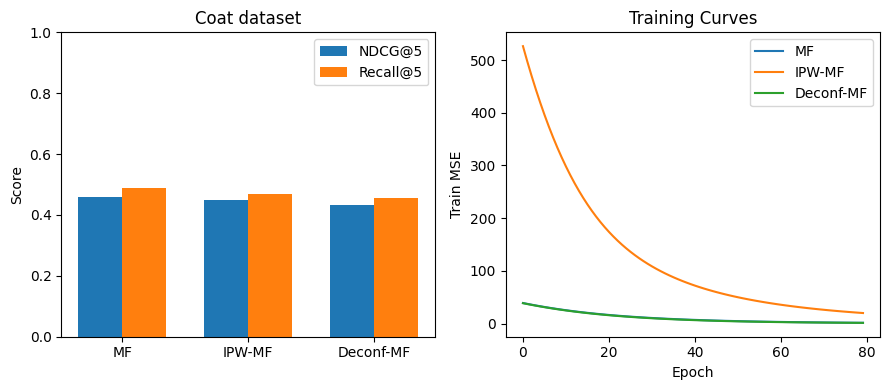

Plotting Yahoo results


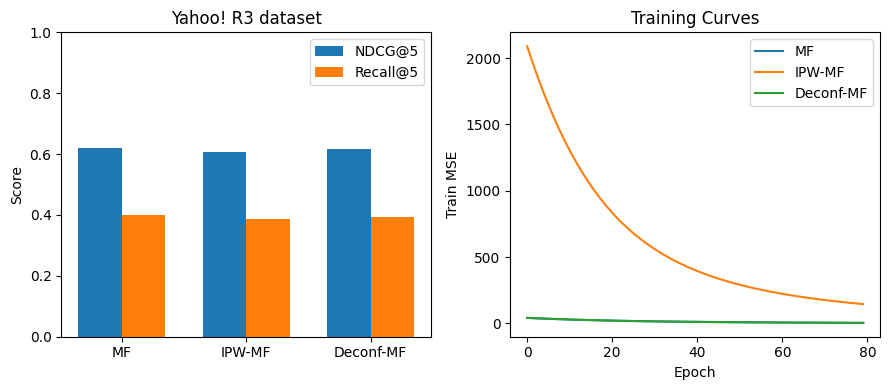

 Coat results: 
Model        NDCG@5     Recall@5  
MF               0.4596     0.4892
IPW-MF           0.4505     0.4681
Deconf-MF        0.4327     0.4542

 Yahoo! R3 results: 
Model        NDCG@5     Recall@5  
MF               0.6196     0.3985
IPW-MF           0.6075     0.3855
Deconf-MF        0.6175     0.3949



In [ ]:
# Summary bar charts and training curves
def plot_results(results, title):
    mf_ndcg = results['mf']['ndcg']
    ipw_ndcg = results['ipw']['ndcg']
    dc_ndcg = results['deconf']['ndcg']
    mf_rec = results['mf']['recall']
    ipw_rec = results['ipw']['recall']
    dc_rec = results['deconf']['recall']

    models = ['MF', 'IPW-MF', 'Deconf-MF']
    ndcgs = [mf_ndcg, ipw_ndcg, dc_ndcg]
    recs = [mf_rec, ipw_rec, dc_rec]

    x = np.arange(len(models))
    width = 0.35
    plt.figure(figsize=(9,4))
    plt.subplot(1,2,1)
    plt.bar(x - width/2, ndcgs, width, label='NDCG@5')
    plt.bar(x + width/2, recs, width, label='Recall@5')
    plt.xticks(x, models)
    plt.title(title)
    plt.ylabel('Score')
    plt.ylim(0,1)
    plt.legend()

    # plotting training curves
    plt.subplot(1,2,2)
    if results['mf']['losses'] is not None:
        plt.plot(results['mf']['losses'], label='MF')
    if results['ipw']['losses'] is not None:
        plt.plot(results['ipw']['losses'], label='IPW-MF')
    if results['deconf']['losses'] is not None:
        plt.plot(results['deconf']['losses'], label='Deconf-MF')
    plt.xlabel('Epoch')
    plt.ylabel('Train MSE')
    plt.title('Training Curves')
    plt.legend()
    plt.tight_layout()
    plt.show()

print("Plotting Coat results")
plot_results(res_coat, 'Coat dataset')
print("Plotting Yahoo results")
plot_results(res_yahoo, 'Yahoo! R3 dataset')

# Print numerical summary tables
def print_table(results, dataset_name):
    print(f" {dataset_name} results: ")
    print("{:12s} {:10s} {:10s}".format('Model','NDCG@5','Recall@5'))
    for name, label in [('mf','MF'), ('ipw','IPW-MF'), ('deconf','Deconf-MF')]:
        print("{:12s} {:10.4f} {:10.4f}".format(label, results[name]['ndcg'], results[name]['recall']))
    print()

print_table(res_coat, 'Coat')
print_table(res_yahoo, 'Yahoo! R3')


In [ ]:
import urllib.request, zipfile
import pandas as pd
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import os


print("Downloading MovieLens 100K...")
url = "https://files.grouplens.org/datasets/movielens/ml-100k.zip"
urllib.request.urlretrieve(url, "ml-100k.zip")

with zipfile.ZipFile("ml-100k.zip", "r") as zip_ref:
    zip_ref.extractall(".")

ratings = pd.read_csv(
    "ml-100k/u.data",
    sep="\t",
    header=None,
    names=["user", "item", "rating", "timestamp"]
)

# Convert IDs to 0-index integers
ratings["user"] = ratings["user"].astype(int) - 1
ratings["item"] = ratings["item"].astype(int) - 1
ratings["rating"] = ratings["rating"].astype(float)

# Count users/items
n_users_ml = ratings["user"].max() + 1
n_items_ml = ratings["item"].max() + 1
print("MovieLens100K:", n_users_ml, "users ×", n_items_ml, "items")

# Train-test split (80/20 random)
mask = np.random.rand(len(ratings)) < 0.8
train_df_ml = ratings[mask].reset_index(drop=True)
test_df_ml  = ratings[~mask].reset_index(drop=True)

# Rename 'user' to 'u' and 'item' to 'i' for compatibility with run_models_on_dataset
train_df_ml = train_df_ml.rename(columns={'user': 'u', 'item': 'i'})
test_df_ml = test_df_ml.rename(columns={'user': 'u', 'item': 'i'})

# EXPOSURE MATRIX A_ml
A_ml = np.zeros((n_users_ml, n_items_ml), dtype=np.int8)
for _, row in train_df_ml.iterrows():
  # print(row.iloc[0])
  # print(row.iloc[1])
  A_ml[int(row.iloc[0]), int(row.iloc[1])] = 1

# SUBSTITUTE CONFOUNDER VIA NMF
K_exp_ml = 40
nmf_ml = NMF(n_components=K_exp_ml, init="nndsvda", max_iter=800, random_state=42)
W_ml = nmf_ml.fit_transform(A_ml)
H_ml = nmf_ml.components_.T
A_tilde_ml = W_ml @ H_ml.T    # reconstructed exposure

# Normalize to avoid extreme values
scaler_ml = MinMaxScaler(feature_range=(1e-3, 0.999))
p_hat_ml = scaler_ml.fit_transform(A_tilde_ml.reshape(-1,1)).reshape(A_tilde_ml.shape)

# Add IPW weights
train_df_ml["ipw"] = 1.0 / np.clip(
p_hat_ml[
    train_df_ml.u.values, train_df_ml.i.values
], 1e-3, None)

print("MovieLens train rows:", len(train_df_ml), " test rows:", len(test_df_ml))


MovieLens100K: 943 users × 1682 items
MovieLens train rows: 80095  test rows: 19905


/usr/local/lib/python3.12/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 800 reached. Increase it to improve convergence.
  warnings.warn(


Running MovieLens experiment...
MovieLens results: {'mf': {'ndcg': np.float64(0.6495654937395642), 'recall': np.float64(0.8837579617832217), 'losses': [46.102439880371094, 44.76380157470703, 43.46682357788086, 42.211002349853516, 40.995750427246094, 39.82034683227539, 38.68403625488281, 37.58596420288086, 36.52523422241211, 35.50090026855469, 34.511985778808594, 33.557456970214844, 32.636287689208984, 31.747406005859375, 30.889745712280273, 30.062225341796875, 29.26374626159668, 28.493236541748047, 27.74960708618164, 27.031787872314453, 26.338716506958008, 25.66934585571289, 25.02263641357422, 24.39757537841797, 23.79316520690918, 23.20842170715332, 22.642391204833984, 22.094125747680664, 21.562725067138672, 21.04729461669922, 20.546958923339844, 20.060882568359375, 19.588247299194336, 19.128257751464844, 18.680150985717773, 18.243196487426758, 17.816679000854492, 17.399921417236328, 16.992284774780273, 16.593149185180664, 16.20193862915039, 15.818111419677734, 15.441166877746582, 15.0

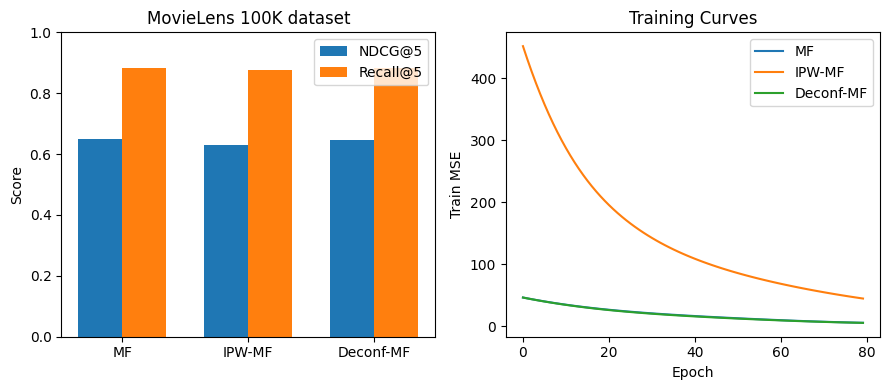

 MovieLens 100K results: 
Model        NDCG@5     Recall@5  
MF               0.6496     0.8838
IPW-MF           0.6307     0.8779
Deconf-MF        0.6466     0.8817

[46.102439880371094, 44.76380157470703, 43.46682357788086, 42.211002349853516, 40.995750427246094, 39.82034683227539, 38.68403625488281, 37.58596420288086, 36.52523422241211, 35.50090026855469, 34.511985778808594, 33.557456970214844, 32.636287689208984, 31.747406005859375, 30.889745712280273, 30.062225341796875, 29.26374626159668, 28.493236541748047, 27.74960708618164, 27.031787872314453, 26.338716506958008, 25.66934585571289, 25.02263641357422, 24.39757537841797, 23.79316520690918, 23.20842170715332, 22.642391204833984, 22.094125747680664, 21.562725067138672, 21.04729461669922, 20.546958923339844, 20.060882568359375, 19.588247299194336, 19.128257751464844, 18.680150985717773, 18.243196487426758, 17.816679000854492, 17.399921417236328, 16.992284774780273, 16.593149185180664, 16.20193862915039, 15.818111419677734, 15.44116

In [ ]:
print("Running MovieLens experiment...")

res_ml = run_models_on_dataset(
    train_df_ml,
    test_df_ml,
    n_users_ml,
    n_items_ml,
    A_tilde=A_tilde_ml,
    K=32,
    epochs=80,
    lr=0.01,
    verbose=False
)

print("MovieLens results:", res_ml)
plot_results(res_ml, "MovieLens 100K dataset")
print_table(res_ml, "MovieLens 100K")
print(res_ml['mf']["losses"])
print(res_ml['ipw']["losses"])
print(res_ml['deconf']["losses"])
